## Setup Codes

In [47]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Google Colab Setup

we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section. Run the following cell to mount your Google Drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now recall the path in your Google Drive where you uploaded this notebook, fill it in below.

In [3]:
import os
import sys

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 'Test' folder and put all the files under 'example' folder, then 'Test/example'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Test/example'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = None
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
sys.path.append(GOOGLE_DRIVE_PATH)

print(os.listdir(GOOGLE_DRIVE_PATH))

['utils', 'convolutional_networks.py']


### Setup Code

Run some setup code for this notebook: Import some useful packages

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim

# custom utils
import utils.utils as utils
import utils.data as data
import utils.modules as modules
import utils.layers as layers

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

### Load the CIFAR-10 dataset
 The utility function eecs598.data.preprocess_cifar10() returns the entire CIFAR-10 dataset as a set of six Torch tensors while also preprocessing the RGB images:

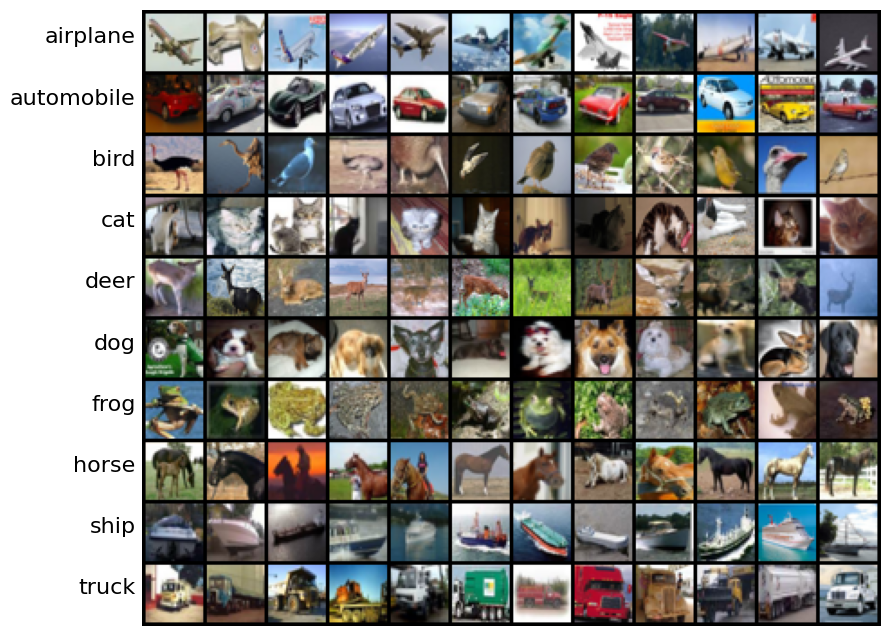

In [65]:
dset_train, dset_val, dset_test = data.load_data(name='cifar10',
                                                 sample_ratio=None,
                                                 show_examples=True,
                                                 flatten=False,
                                                 val_ratio=0.2)

data_loaders = {}
data_loaders['train'] = torch.utils.data.DataLoader(dset_train, batch_size=64, shuffle=True)
data_loaders['val'] = torch.utils.data.DataLoader(dset_val, batch_size=64, shuffle=True)
data_loaders['test'] = torch.utils.data.DataLoader(dset_test, batch_size=64, shuffle=False)

## Simple Convolutional Networks

In [135]:
class Conv2d(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1):
    super().__init__()

    self.stride = stride
    self.pad = padding

    self.W = nn.Parameter(modules.kaiming_init(in_channels, out_channels, kernel_size))
    self.b = nn.Parameter(torch.zeros(out_channels))

  def forward(self, x):
    N, _, H, W = x.shape
    F, _, HH, WW = self.W.shape


    H_out = 1 + (H + 2 * self.pad - HH) // self.stride
    W_out = 1 + (W + 2 * self.pad - WW) // self.stride

    padded_x = torch.nn.functional.pad(x, (self.pad, self.pad, self.pad, self.pad))
    unfolded_x = torch.nn.functional.unfold(padded_x, kernel_size=(HH, WW), stride=self.stride)

    reshaped_w = self.W.view(F, -1).to(x.device)
    out = torch.matmul(reshaped_w, unfolded_x) + self.b.unsqueeze(-1).to(x.device)

    return out.view(N, F, H_out, W_out)


In [136]:
class MaxPool2d(nn.Module):
  def __init__(self, kernel_size=2, stride=1):
    super().__init__()

    self.stride = stride
    self.kernel_size = kernel_size

  def forward(self, x):
    N, C, H, W = x.shape

    H_out = 1 + (H - self.kernel_size) // self.stride
    W_out = 1 + (W - self.kernel_size ) // self.stride

    unfolded_x = torch.nn.functional.unfold(x, kernel_size=(self.kernel_size, self.kernel_size), stride=self.stride)
    unfolded_x = unfolded_x.view(N, C, self.kernel_size, self.kernel_size, -1)

    pooled_x = unfolded_x.amax(dim=(2,3))
    out = pooled_x.view(N, C, H_out, W_out)

    return out


In [137]:
class SimpleConvNet(nn.Module):

    def __init__(self,
                 input_dims=(3, 32, 32),
                 num_filters=32,
                 filter_size=7,
                 hidden_dim=100,
                 num_classes=10,):
        super().__init__()

        C, H, W = input_dims
        flatten_dim = num_filters * H * W // 4

        self.relu = modules.ReLU()

        self.conv = Conv2d(C, num_filters, filter_size,
                           stride=1,
                           padding=(filter_size - 1) // 2)

        self.pool = MaxPool2d(kernel_size=2, stride=2)
        self.fc = layers.Linear(flatten_dim, hidden_dim)
        self.outlayer = layers.Linear(hidden_dim, num_classes)

    def forward(self, x):

        out = self.conv(x)
        out = self.relu(out)
        out = self.pool(out)

        flatten_out = out.reshape(x.shape[0], -1)

        out = self.fc(flatten_out)
        out = self.relu(out)
        out = self.outlayer(out)

        return out

## Sanity Check

In [138]:
model = SimpleConvNet()
criterion = nn.CrossEntropyLoss()

N = 50
x = torch.randn(N, 3, 32, 32)
y = torch.randint(10, size=(N,), dtype=torch.int64)

out = model(x)
loss = criterion(out, y)
print('loss : ', loss.item())

loss.backward()

loss :  3.690603733062744


In [151]:
dset_train, dset_val, dset_test = data.load_data(name='cifar10',
                                                 sample_ratio=0.005,
                                                 show_examples=False,
                                                 flatten=False,
                                                 val_ratio=0.2)

print(f"number of train samples : {len(dset_train)}")
print(f"number of val samples : {len(dset_val)}")
print(f"number of test samples : {len(dset_test)}")

sample_loaders = {}
sample_loaders['train'] =  torch.utils.data.DataLoader(dset_train, batch_size=64, shuffle=True)
sample_loaders['val'] = torch.utils.data.DataLoader(dset_val, batch_size=64, shuffle=True)
sample_loaders['test'] = torch.utils.data.DataLoader(dset_test, batch_size=64, shuffle=False)

model = SimpleConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

history = utils.runner(model, criterion, optimizer, sample_loaders, num_epochs=20, msg=True)

number of train samples : 200
number of val samples : 50
number of test samples : 50
Train using cpu
Epoch [1/20]          train Loss: 2.6260          train ACC: 10.50%          val Loss: 2.6671          val ACC: 22.00%
Epoch [2/20]          train Loss: 2.0784          train ACC: 30.00%          val Loss: 2.0640          val ACC: 38.00%
Epoch [3/20]          train Loss: 1.7609          train ACC: 35.50%          val Loss: 2.1114          val ACC: 32.00%
Epoch [4/20]          train Loss: 1.4520          train ACC: 47.50%          val Loss: 2.2141          val ACC: 28.00%
Epoch [5/20]          train Loss: 1.3913          train ACC: 59.50%          val Loss: 2.1485          val ACC: 30.00%
Epoch [6/20]          train Loss: 1.0992          train ACC: 67.50%          val Loss: 2.2757          val ACC: 32.00%
Epoch [7/20]          train Loss: 0.8683          train ACC: 72.50%          val Loss: 2.3141          val ACC: 26.00%
Epoch [8/20]          train Loss: 0.8242          train ACC: 79.00

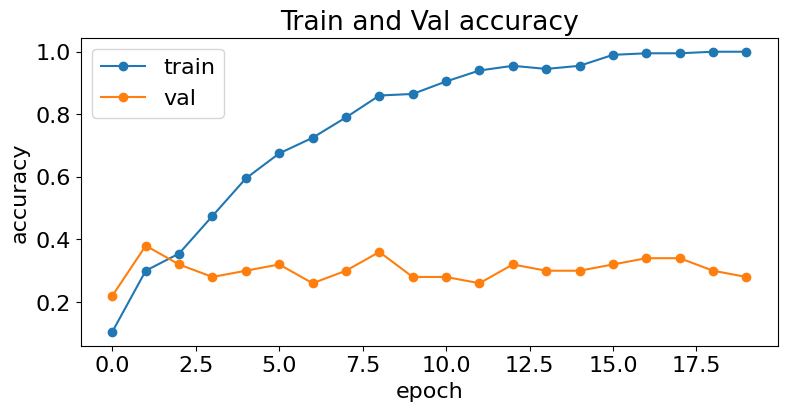

In [153]:
utils.visulaize_history(history['trainACC'], history['valACC'], title='accuracy')

## Train the net

In [155]:
model = SimpleConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

history = utils.runner(model, criterion, optimizer, data_loaders, num_epochs=10, msg=True)

Train using cpu
Epoch [1/10]          train Loss: 1.4596          train ACC: 48.62%          val Loss: 1.2383          val ACC: 56.16%
Epoch [2/10]          train Loss: 1.1209          train ACC: 60.92%          val Loss: 1.1407          val ACC: 59.68%
Epoch [3/10]          train Loss: 0.9801          train ACC: 65.96%          val Loss: 1.0701          val ACC: 63.06%
Epoch [4/10]          train Loss: 0.8843          train ACC: 69.12%          val Loss: 1.0119          val ACC: 65.43%
Epoch [5/10]          train Loss: 0.8162          train ACC: 71.57%          val Loss: 1.0250          val ACC: 64.90%
Epoch [6/10]          train Loss: 0.7467          train ACC: 74.00%          val Loss: 1.0292          val ACC: 65.21%
Epoch [7/10]          train Loss: 0.6848          train ACC: 76.08%          val Loss: 1.0430          val ACC: 65.71%
Epoch [8/10]          train Loss: 0.6286          train ACC: 78.00%          val Loss: 1.0866          val ACC: 65.23%
Epoch [9/10]          train Loss